In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
df_country = pd.read_csv('../data/data_annees.csv')
for column in df_country.columns:
    if column != 'Country':
        df_country[column] = pd.to_numeric(df_country[column], errors='coerce')
df_fast = pd.read_pickle('../data/fastfashion_clean.pkl')
df_slow = pd.read_pickle('../data/slowfashion_clean.pkl')
base = pd.read_pickle('base.pkl')

In [3]:
# replace 'Korea' with 'South Korea'
base['Country'] = base['Country'].apply(lambda x: [country.replace('Korea', 'South Korea') for country in x])
#base['Country'] = base['Country'].astype(str).apply(eval)
base['Country'] = base['Country'].replace('Korea', 'South Korea')
df_country['Country'] = df_country['Country'].astype(str)
base = base.explode('Country')

fashion_aggregated = base.groupby(['Country', 'Brand Type']).agg({
    'Price': 'mean'
}).reset_index()
fashion_aggregated.head(5)

,Country,Brand Type,Price
0,Bangladesh,Fast Fashion,22.373367
1,Bangladesh,Slow Fashion,118.000000
2,Bulgaria,Fast Fashion,12.240000
3,Cambodia,Fast Fashion,14.490000
4,China,Fast Fashion,28.883294


In [4]:
# pivot table
fashion_pivot = fashion_aggregated.pivot(index='Country', columns='Brand Type', values='Price').fillna(0)
fashion_pivot.columns = ['Avg Price Fast Fashion', 'Avg Price Slow Fashion']
fashion_pivot = fashion_pivot.reset_index()
fashion_pivot.head(5)

,Country,Avg Price Fast Fashion,Avg Price Slow Fashion
0,Bangladesh,22.373367,118.000000
1,Bulgaria,12.240000,0.000000
2,Cambodia,14.490000,0.000000
3,China,28.883294,133.848485
4,Ethiopia,7.990000,0.000000


In [5]:
countries_slow_fashion = df_slow['Country'].explode().unique()
countries_fast_fashion = set(base[base['Brand Type'] == 'Fast Fashion']['Country'])
countries_slow_fashion = ["South Korea" if c == "Korea" else c for c in countries_slow_fashion]
countries_with_fashion_data = countries_fast_fashion.union(set(countries_slow_fashion))

# include only countries with fashion data
df_country_filtered = df_country[df_country['Country'].isin(countries_with_fashion_data)]

df_combined = pd.merge(df_country_filtered, fashion_pivot, on='Country', how='inner')

# averages of the columns to have one country per row
df_combined_avg = df_combined.groupby('Country').mean()
df_combined_avg = df_combined_avg.reset_index()
df_combined_avg.drop(columns=['Year', 'Generated'], inplace=True)
df_combined_avg.head()

,Country,Quality of Life Index,Purchasing Power Index,Safety Index,Health Care Index,Cost of Living Index,Property Price to Income Ratio,Traffic Commute Time Index,Pollution Index,Climate Index,Avg Price Fast Fashion,Avg Price Slow Fashion
0,Bangladesh,56.116667,28.116667,36.700000,42.616667,31.566667,12.866667,57.366667,86.733333,71.940000,22.373367,118.000000
1,Bulgaria,120.209091,48.545455,60.436364,55.390909,40.009091,8.890909,30.072727,63.845455,81.477778,12.240000,0.000000
2,Cambodia,-4.400000,11.900000,55.900000,54.200000,57.000000,21.100000,33.300000,80.100000,NaN,14.490000,0.000000
3,China,87.236364,61.818182,66.790909,64.272727,43.390909,28.127273,40.200000,83.345455,70.988889,28.883294,133.848485
4,India,105.527273,65.181818,55.527273,66.536364,24.736364,10.681818,46.472727,75.872727,53.777778,18.369310,0.000000


In [6]:
df_combined_avg['Country'].value_counts()

Country
Bangladesh     1
Bulgaria       1
Cambodia       1
China          1
India          1
Indonesia      1
Kenya          1
Mexico         1
Morocco        1
Pakistan       1
Peru           1
Romania        1
South Korea    1
Sri Lanka      1
Turkey         1
Vietnam        1
Name: count, dtype: int64

In [7]:
df_country['Country'] = df_country['Country'].astype(str).str.strip()
base['Country'] = base['Country'].astype(str).str.strip()

total_products_per_country = base['Country'].value_counts()
fast_fashion_per_country = base[base['Brand Type'] == 'Fast Fashion']['Country'].value_counts()
slow_fashion_per_country = base[base['Brand Type'] == 'Slow Fashion']['Country'].value_counts()

fashion_counts = pd.DataFrame({
    'Total': total_products_per_country,
    'Fast Fashion': fast_fashion_per_country,
    'Slow Fashion': slow_fashion_per_country
}).fillna(0)

fashion_counts['Fast Fashion Proportion'] = fashion_counts['Fast Fashion'] / fashion_counts['Total']
fashion_counts['Slow Fashion Proportion'] = fashion_counts['Slow Fashion'] / fashion_counts['Total']

df = pd.merge(df_combined_avg, fashion_counts[['Fast Fashion Proportion', 'Slow Fashion Proportion']], 
                       left_on='Country', right_index=True, how='inner')
df= df.fillna(0)

df.head()

,Country,Quality of Life Index,Purchasing Power Index,Safety Index,Health Care Index,Cost of Living Index,Property Price to Income Ratio,Traffic Commute Time Index,Pollution Index,Climate Index,Avg Price Fast Fashion,Avg Price Slow Fashion,Fast Fashion Proportion,Slow Fashion Proportion
0,Bangladesh,56.116667,28.116667,36.700000,42.616667,31.566667,12.866667,57.366667,86.733333,71.940000,22.373367,118.000000,0.989960,0.010040
1,Bulgaria,120.209091,48.545455,60.436364,55.390909,40.009091,8.890909,30.072727,63.845455,81.477778,12.240000,0.000000,1.000000,0.000000
2,Cambodia,-4.400000,11.900000,55.900000,54.200000,57.000000,21.100000,33.300000,80.100000,0.000000,14.490000,0.000000,1.000000,0.000000
3,China,87.236364,61.818182,66.790909,64.272727,43.390909,28.127273,40.200000,83.345455,70.988889,28.883294,133.848485,0.947702,0.052298
4,India,105.527273,65.181818,55.527273,66.536364,24.736364,10.681818,46.472727,75.872727,53.777778,18.369310,0.000000,1.000000,0.000000


In [8]:
tmp1 = df.copy()
tmp2 = df.copy()

/Users/aylinsoykok/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/aylinsoykok/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/aylinsoykok/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/aylinsoykok/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default 

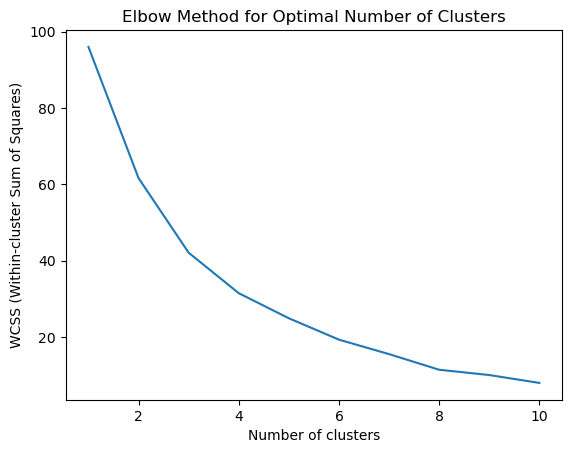

In [9]:
# first clustering the countries based on general info (not fashion)
features = ['Quality of Life Index', 'Purchasing Power Index', 'Safety Index', 
            'Health Care Index', 'Cost of Living Index', 'Pollution Index']

# normalization
X = tmp1[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS (Within-cluster Sum of Squares)')
plt.show()

In [10]:
kmeans = KMeans(n_clusters=4, random_state=42)
tmp1['Cluster'] = kmeans.fit_predict(X_scaled)

cluster_summary = tmp1.groupby('Cluster')[features].mean()
print(cluster_summary)

         Quality of Life Index  Purchasing Power Index  Safety Index  \
Cluster                                                                
0                    79.446936               30.433030     43.761869   
1                   103.748864               46.802273     59.088778   
2                   140.445455               92.454545     74.954545   
3                    -4.400000               11.900000     55.900000   

         Health Care Index  Cost of Living Index  Pollution Index  
Cluster                                                            
0                52.782340             32.693771        78.756650  
1                64.449858             36.271449        67.643324  
2                81.827273             76.936364        61.018182  
3                54.200000             57.000000        80.100000  


/Users/aylinsoykok/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


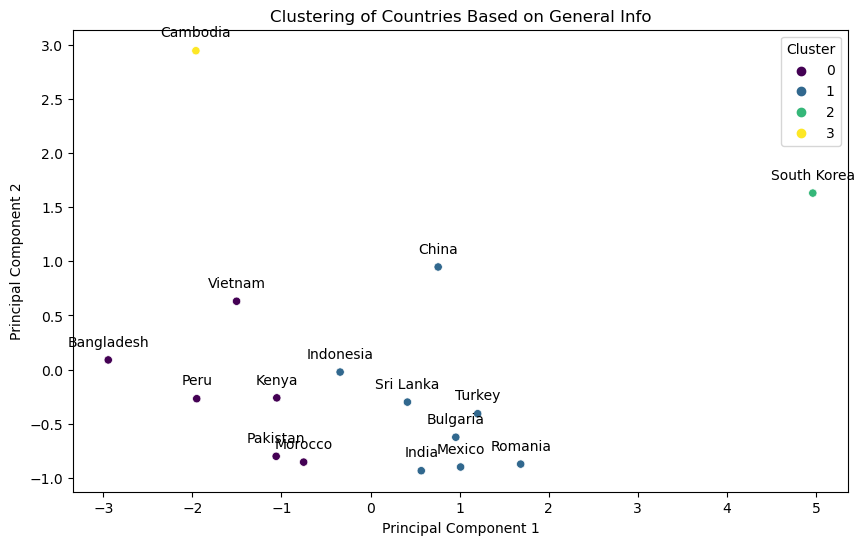

In [11]:
# choosing 2 dims with PCA for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
principal_df['Cluster'] = tmp1['Cluster']

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=principal_df, palette='viridis')
for i, country in enumerate(tmp1['Country']):
    plt.annotate(country, (principal_df['PC1'][i], principal_df['PC2'][i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Clustering of Countries Based on General Info')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

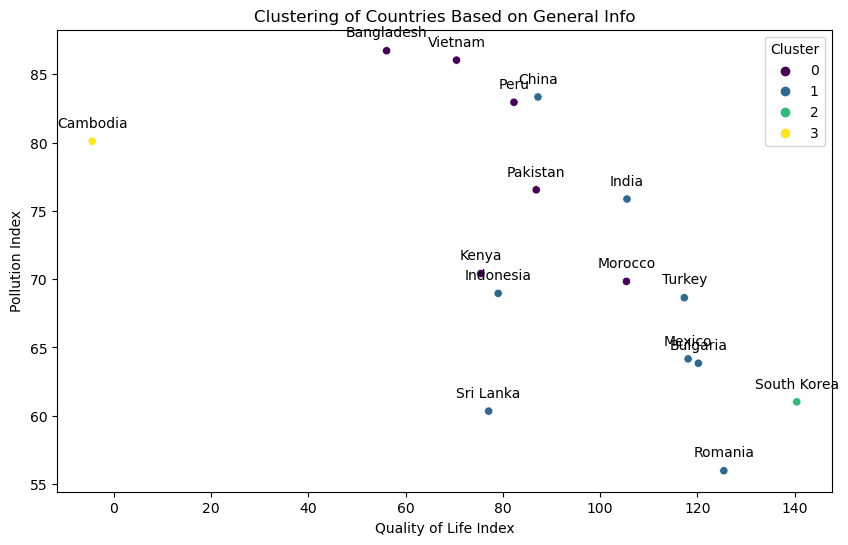

In [12]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Quality of Life Index', y='Pollution Index', hue='Cluster', data=tmp1, palette='viridis')

for i, country in enumerate(tmp1['Country']):
    plt.annotate(country, (tmp1['Quality of Life Index'][i], tmp1['Pollution Index'][i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Clustering of Countries Based on General Info')
plt.xlabel('Quality of Life Index')
plt.ylabel('Pollution Index')
plt.legend(title='Cluster')
plt.show()

/Users/aylinsoykok/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/aylinsoykok/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/aylinsoykok/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/aylinsoykok/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default 

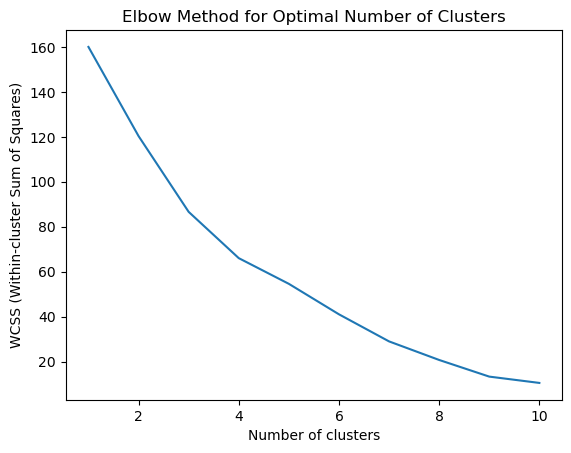

In [19]:
# now including fashion info

features = ['Quality of Life Index', 'Purchasing Power Index', 'Safety Index', 
            'Health Care Index', 'Cost of Living Index', 'Pollution Index', 
            'Avg Price Fast Fashion', 'Avg Price Slow Fashion', 
            'Fast Fashion Proportion', 'Slow Fashion Proportion']

# normalization
X = tmp2[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS (Within-cluster Sum of Squares)')
plt.show()

/Users/aylinsoykok/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


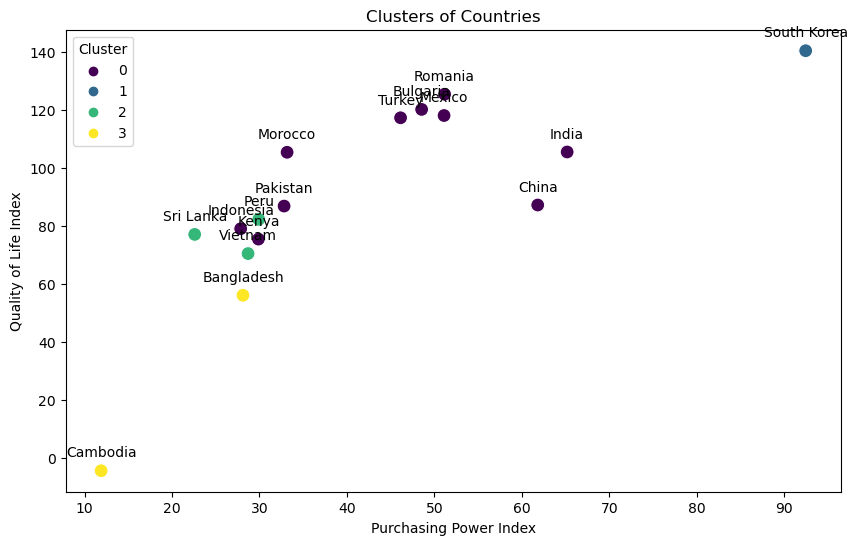

In [20]:
kmeans = KMeans(n_clusters=4, random_state=42)
tmp2['Cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Purchasing Power Index', y='Quality of Life Index', hue='Cluster', data=tmp2, palette='viridis', s=100)
plt.title('Clusters of Countries')
for i, country in enumerate(tmp2['Country']):
    plt.annotate(country, (tmp2['Purchasing Power Index'][i], tmp2['Quality of Life Index'][i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('Purchasing Power Index')
plt.ylabel('Quality of Life Index')
plt.legend(title='Cluster')
plt.show()


/Users/aylinsoykok/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


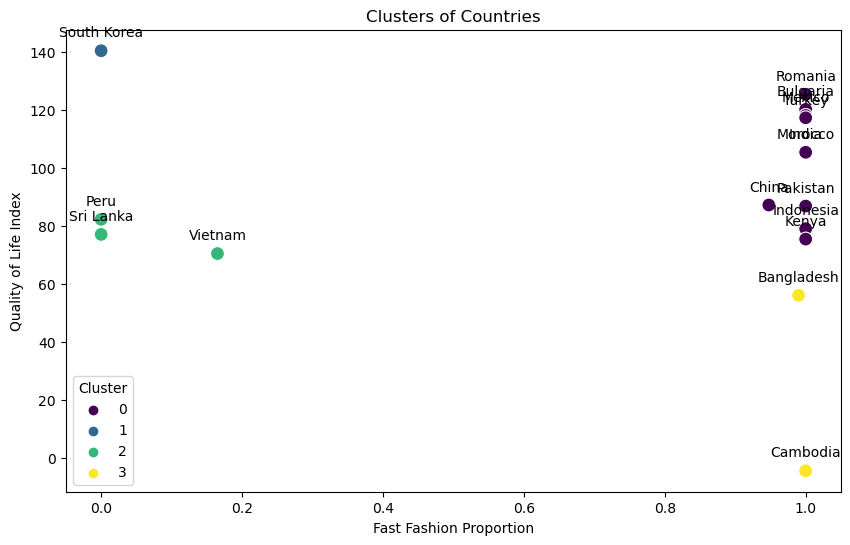

In [21]:
kmeans = KMeans(n_clusters=4, random_state=42)
tmp2['Cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Fast Fashion Proportion', y='Quality of Life Index', hue='Cluster', data=tmp2, palette='viridis', s=100)
plt.title('Clusters of Countries')
for i, country in enumerate(tmp2['Country']):
    plt.annotate(country, (tmp2['Fast Fashion Proportion'][i], tmp2['Quality of Life Index'][i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('Fast Fashion Proportion')
plt.ylabel('Quality of Life Index')
plt.legend(title='Cluster')
plt.show()


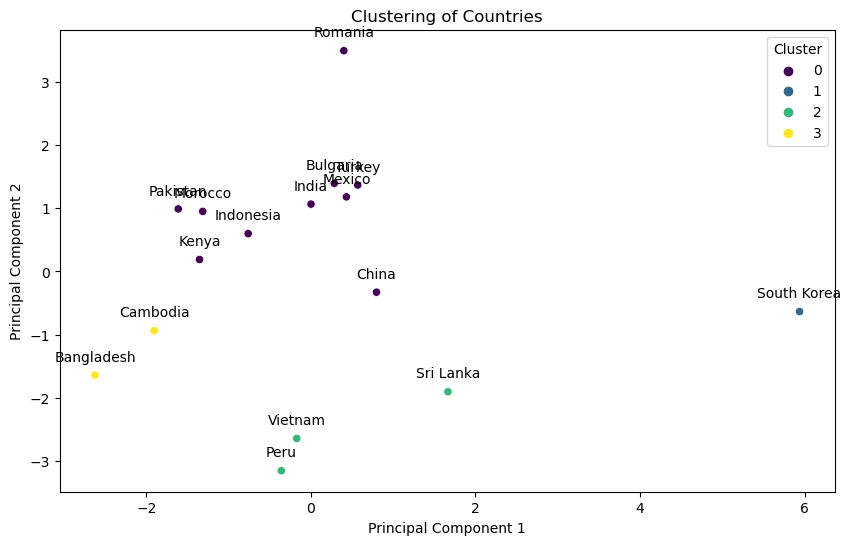

In [23]:
# now with PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
principal_df['Cluster'] = tmp2['Cluster']

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=principal_df, palette='viridis')
for i, country in enumerate(tmp2['Country']):
    plt.annotate(country, (principal_df['PC1'][i], principal_df['PC2'][i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Clustering of Countries')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()